# Source panel method

before, using our superposition powers we could get some useful results in aerodynamics.The superposition of a doublet and a free stream gave the flow around a circular cylinder

D'Alembert paradox: the result of zero drag for potential flow around a cylinder. Adding a vortex at the center of the cylinder, we learned about lift and the Kutta-Joukowski theorem stating that lift is proporional to circulation: $L=\rho U \Gamma$. A most important result!

Adding together fundamental solutions of potential flow and seeing what we get when interpreting a dividing streamline as a solid body is often called an indirect method.

In Lesson 9, we learned that it is possible to stipulate first the geometry, and then solve for the source strengths on a panel discretization of the body that makes the flow tangent at the boundary. This is called a direct method

A set of panels (line segments in 2D) can represent the surface of any solid body immersed in a potential flow by making the source-sheet strengths such that the normal velocity at each panel is equal to zero. This is a very powerful idea! But you should realize that all the panel strengths are coupled to each other, which is why we end up with a linear system of equations.

For an arbitrary geometry, we need to build a set of panels according to some points that define the geometry

In [22]:
import os
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

In [23]:
# read of the geometry from a data file
x, y = numpy.loadtxt("../AeroPython/lessons/resources/naca0012.dat", dtype=float, delimiter='\t', unpack=True)

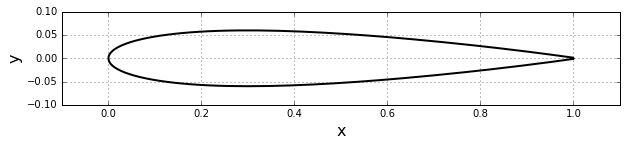

In [24]:
#plot
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth = 2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

# Discretization into panels

In [26]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is on the lower or upper surface of the geometry.
        Initializes the source-sheet strength, tangential velocity,
        and pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2    #(center point, control points)
        self.length = numpy.sqrt((xb-xa)**2 + (yb-ya)**2)
        
        # orientation of the panel (angle between x-axis and panel's normal)
         # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
                
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient    

To store all the discretization, we create a NumPy array of size N_panels where each item in the array is an object of type Panel.